### Qwen2-1.5b推理

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
from modelscope import AutoModelForCausalLM, AutoTokenizer

model_path = '/data01/tqbian/modelPATH/Qwen/Qwen2___5-1___5B-Instruct'

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_path)

prompt = "北京奥运会"
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(response)

北京奥运会是2008年夏季奥林匹克运动会，这是中国举办的第一次奥运会。该届奥运会于2008年7月26日开幕，8月13日闭幕。

在本次奥运会上，中国代表团取得了51枚金牌、21枚银牌和28枚铜牌的优异成绩，位居奖牌榜首位。此外，中国运动员还创下了多项世界纪录和奥运记录。

北京奥运会的成功举办不仅展示了中国的经济实力和发展水平，也体现了中国政府对体育事业的支持和投入。


### 数据集加载

In [3]:
from datasets import load_dataset
ds = load_dataset('json', data_files="/data01/tqbian/src/learning/LLM_Toturials/LoRa_Qwen2.5/alapca_data_zh/alpaca_gpt4_data_zh.json")

In [4]:
print(ds)
print(ds.column_names)
ds['train'][2]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 48818
    })
})
{'train': ['instruction', 'input', 'output']}


{'instruction': '描述原子的结构。',
 'input': '',
 'output': '原子是物质的基本单位，它由三种基本粒子组成：质子、中子和电子。质子和中子形成原子核，位于原子中心，核外的电子围绕着原子核运动。\n\n原子结构具有层次性。原子核中，质子带正电，中子不带电（中性）。原子核非常小且致密，占据了原子总质量的绝大部分。电子带负电，通常围绕核运动，形成若干层次，称为壳层或电子层。电子数量与质子数量相等，使原子呈电中性。\n\n电子在每个壳层中都呈规律分布，并且不同壳层所能容纳的电子数也不同。在最里面的壳层一般只能容纳2个电子，其次一层最多可容纳8个电子，再往外的壳层可容纳的电子数逐层递增。\n\n原子核主要受到两种相互作用力的影响：强力和电磁力。强力的作用范围非常小，主要限制在原子核内，具有极强的吸引作用，使核子（质子和中子）紧密结合在一起。电磁力的作用范围较大，主要通过核外的电子与原子核相互作用，发挥作用。\n\n这就是原子的基本结构。原子内部结构复杂多样，不同元素的原子核中质子、中子数量不同，核外电子排布分布也不同，形成了丰富多彩的化学世界。'}

In [5]:
def process_func(example):
    MAX_LENGTH = 256
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [6]:
tokenized_ds = ds['train'].map(process_func)
tokenized_ds

Dataset({
    features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 48818
})

In [7]:
tokenizer.decode(tokenized_ds[2]["input_ids"])

'Human: 描述原子的结构。\n\nAssistant: 原子是物质的基本单位，它由三种基本粒子组成：质子、中子和电子。质子和中子形成原子核，位于原子中心，核外的电子围绕着原子核运动。\n\n原子结构具有层次性。原子核中，质子带正电，中子不带电（中性）。原子核非常小且致密，占据了原子总质量的绝大部分。电子带负电，通常围绕核运动，形成若干层次，称为壳层或电子层。电子数量与质子数量相等，使原子呈电中性。\n\n电子在每个壳层中都呈规律分布，并且不同壳层所能容纳的电子数也不同。在最里面的壳层一般只能容纳2个电子，其次一层最多可容纳8个电子，再往外的壳层可容纳的电子数逐层递增。\n\n原子核主要受到两种相互作用力的影响：强力和电磁力。强力的作用范围非常小，主要限制在原子核内，具有极强的吸引作用，使核子（质子和中子）紧密结合在一起。电磁力的作用范围较大，主要通过核外的电子与原子核相互作用'

In [8]:
tokenizer.decode(list(filter(lambda x: x != -100, tokenized_ds[1]["labels"])))

'三原色通常指的是红色、绿色和蓝色（RGB）。它们是通过加色混合原理创建色彩的三种基础颜色。在以发光为基础的显示设备中（如电视、计算机显示器、智能手机和平板电脑显示屏）, 三原色可混合产生大量色彩。其中红色和绿色可以混合生成黄色，红色和蓝色可以混合生成品红色，蓝色和绿色可以混合生成青色。当红色、绿色和蓝色按相等比例混合时，可以产生白色或灰色。\n\n此外，在印刷和绘画中，三原色指的是以颜料为基础的红、黄和蓝颜色（RYB）。这三种颜色用以通过减色混合原理来创建色彩。不过，三原色的具体定义并不唯一，不同的颜色系统可能会采用不同的三原色。<|im_end|>'

In [9]:
len(tokenized_ds[1]['labels'])

177

In [10]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qw

In [11]:
for name, parameter in model.named_parameters():
    print(name)

model.embed_tokens.weight
model.layers.0.self_attn.q_proj.weight
model.layers.0.self_attn.q_proj.bias
model.layers.0.self_attn.k_proj.weight
model.layers.0.self_attn.k_proj.bias
model.layers.0.self_attn.v_proj.weight
model.layers.0.self_attn.v_proj.bias
model.layers.0.self_attn.o_proj.weight
model.layers.0.mlp.gate_proj.weight
model.layers.0.mlp.up_proj.weight
model.layers.0.mlp.down_proj.weight
model.layers.0.input_layernorm.weight
model.layers.0.post_attention_layernorm.weight
model.layers.1.self_attn.q_proj.weight
model.layers.1.self_attn.q_proj.bias
model.layers.1.self_attn.k_proj.weight
model.layers.1.self_attn.k_proj.bias
model.layers.1.self_attn.v_proj.weight
model.layers.1.self_attn.v_proj.bias
model.layers.1.self_attn.o_proj.weight
model.layers.1.mlp.gate_proj.weight
model.layers.1.mlp.up_proj.weight
model.layers.1.mlp.down_proj.weight
model.layers.1.input_layernorm.weight
model.layers.1.post_attention_layernorm.weight
model.layers.2.self_attn.q_proj.weight
model.layers.2.self

### lora参数设置

In [11]:
from peft import LoraConfig, TaskType, get_peft_model
config = LoraConfig(task_type=TaskType.CAUSAL_LM, target_modules=['q_proj', 'v_proj'], r=16, lora_alpha=16)
config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.CAUSAL_LM: 'CAUSAL_LM'>, inference_mode=False, r=16, target_modules={'q_proj', 'v_proj'}, lora_alpha=16, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [12]:
lora_model = get_peft_model(model, config)  
print(lora_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1536)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2SdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1536, out_features=1536, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1536, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=1536, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear(in_features=1536, out_features=256, bias=True)
              (v_proj): lora

In [54]:
for name, parameter in lora_model.named_parameters():
    print(name)

base_model.model.model.embed_tokens.weight
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight
base_model.model.model.layers.0.self_attn.q_proj.base_layer.bias
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.k_proj.weight
base_model.model.model.layers.0.self_attn.k_proj.bias
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight
base_model.model.model.layers.0.self_attn.v_proj.base_layer.bias
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.o_proj.weight
base_model.model.model.layers.0.mlp.gate_proj.weight
base_model.model.model.layers.0.mlp.up_proj.weight
base_model.model.model.layers.0.mlp.down_proj.weight
base_model.model.model.layers.0.input_layernorm.weight
base_model.model.model.layers.0

In [13]:
lora_model.print_trainable_parameters()  

trainable params: 2,179,072 || all params: 1,545,893,376 || trainable%: 0.1410


### lora模型训练

In [14]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer
args = TrainingArguments(
    output_dir="/data01/tqbian/src/learning/LLM_Toturials/LoRa_Qwen2.5/output_model/",  
    per_device_train_batch_size=32,  
    gradient_accumulation_steps=8,  
    logging_steps=50,  
    num_train_epochs=3 
    
)
trainer = Trainer(
    model=lora_model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True),
)  

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [15]:
trainer.train()  

Step,Training Loss
50,1.730400
100,1.641700
150,1.557600
200,1.538600
250,1.538700
300,1.531700
350,1.539300
400,1.538000
450,1.534600
500,1.532000


/data01/tqbian/miniconda3/envs/chatchat/lib/python3.9/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /data01/tqbian/modelPATH/Qwen/Qwen2___5-1___5B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/data01/tqbian/miniconda3/envs/chatchat/lib/python3.9/site-packages/peft/utils/save_and_load.py:195: UserWarning: Could not find a config file in /data01/tqbian/modelPATH/Qwen/Qwen2___5-1___5B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


TrainOutput(global_step=570, training_loss=1.5643828977618301, metrics={'train_runtime': 2196.3415, 'train_samples_per_second': 66.681, 'train_steps_per_second': 0.26, 'total_flos': 2.941015137760051e+17, 'train_loss': 1.5643828977618301, 'epoch': 2.9882044560943646})

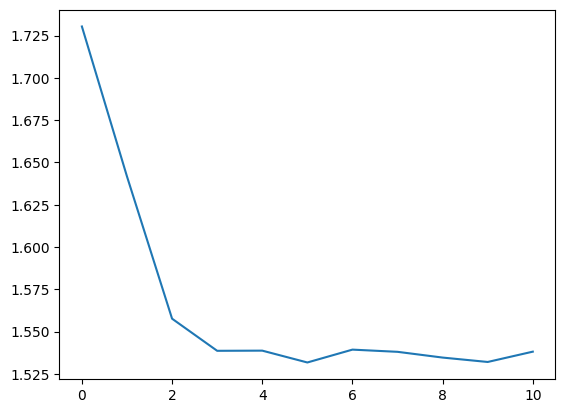

In [16]:
import matplotlib.pyplot as plt
log_history = trainer.state.log_history
losses = [entry["loss"] for entry in log_history if "loss" in entry]
plt.plot(losses)